## Analysis of Days of Week based on Fremont Bicycle Data
Treating crossings each day as features to learn about the relationships between various days

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

## Get Data

In [2]:
FILENAME = '../data/Fremont_Bridge_Hourly_Bicycle_Counts_by_Month_October_2012_to_present.csv'
URL = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'

def get_fremont_data(filename=FILENAME, url=URL, force_download=False):
    if force_download or not os.path.exists(filename):
        urlretrieve(url, filename)
    data = pd.read_csv(filename, index_col='Date', parse_dates=True)
    data.columns = ['West', 'East']
    data['Total'] = data['West'] + data['East']
    return data


In [3]:
data = get_fremont_data()
data.head()

,West,East,Total
Date,,,
2019-03-31 23:00:00,6.0,10.0,16.0
2019-03-31 22:00:00,7.0,14.0,21.0
2019-03-31 21:00:00,18.0,15.0,33.0
2019-03-31 20:00:00,26.0,31.0,57.0
2019-03-31 19:00:00,30.0,58.0,88.0


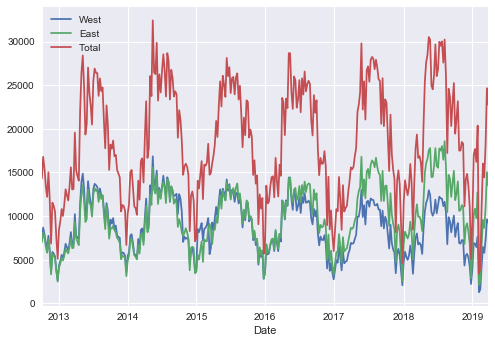

In [4]:
plt.style.use('seaborn')
data.resample('W').sum().plot()

(0, 1100992.6)

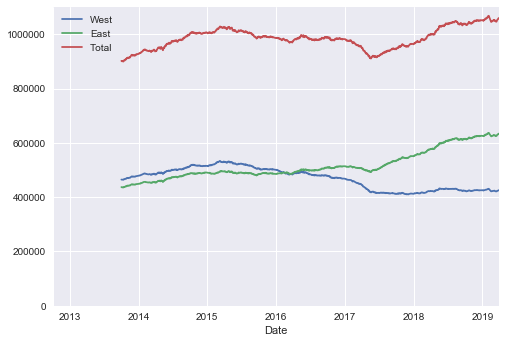

In [5]:
ax = data.resample('D').sum().rolling(365).sum().plot()
ax.set_ylim(0, None)

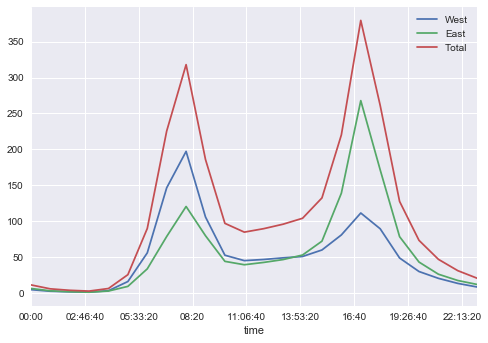

In [6]:
data.groupby(data.index.time).mean().plot()

In [7]:
pivoted = data.pivot_table('Total', index=data.index.time, columns=data.index.date)
pivoted.iloc[:5, :5]

,2012-10-03,2012-10-04,2012-10-05,2012-10-06,2012-10-07
00:00:00,13.0,18.0,11.0,15.0,11.0
01:00:00,10.0,3.0,8.0,15.0,17.0
02:00:00,2.0,9.0,7.0,9.0,3.0
03:00:00,5.0,3.0,4.0,3.0,6.0
04:00:00,7.0,8.0,9.0,5.0,3.0


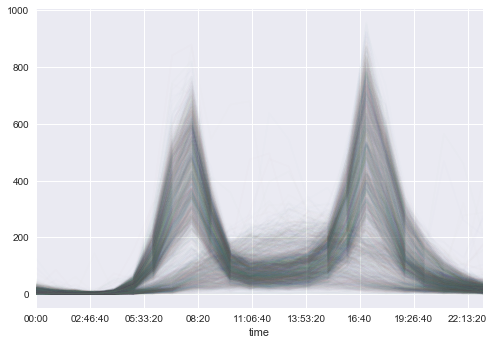

In [8]:
pivoted.plot(legend=False, alpha=0.01)

## Principle Component Analysis

In [9]:
X = pivoted.fillna(0).T.values
X.shape

(2371, 24)

In [10]:
X2 = PCA(2, svd_solver='full').fit_transform(X)

In [11]:
X2.shape

(2371, 2)

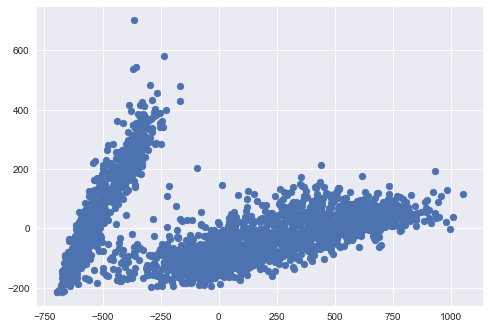

In [12]:
plt.scatter(X2[:, 0], X2[:, 1])

## Unsupervised Clustering

In [13]:
qmm = GaussianMixture(2)
qmm.fit(X)
labels = qmm.predict(X)
labels

array([1, 1, 1, ..., 1, 0, 0], dtype=int64)

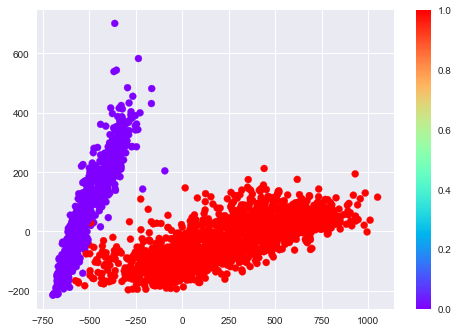

In [14]:
plt.scatter(X2[:, 0], X2[:, 1], c=labels, cmap='rainbow')
plt.colorbar()

Text(0.5, 1.0, 'Red Cluster')

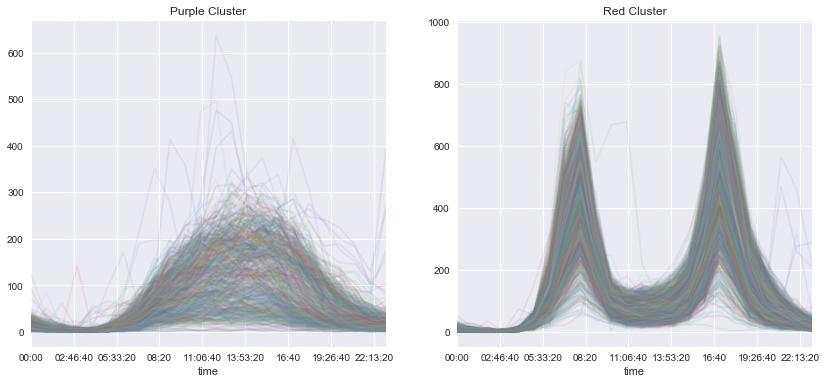

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

pivoted.T[labels == 0].T.plot(legend=False, alpha=0.1, ax=ax[0])
pivoted.T[labels == 1].T.plot(legend=False, alpha=0.1, ax=ax[1])

ax[0].set_title('Purple Cluster')
ax[1].set_title('Red Cluster')

## Comparing with Day of Week

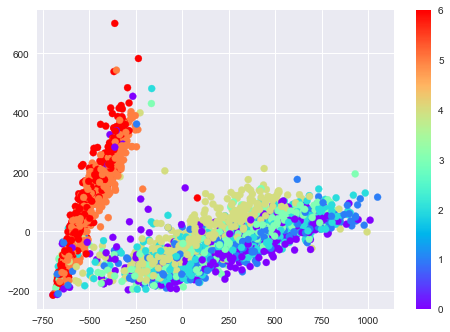

In [16]:
dayofweek = pd.DatetimeIndex(pivoted.columns).dayofweek
plt.scatter(X2[:, 0], X2[:, 1], c=dayofweek, cmap='rainbow')
plt.colorbar()

## Analyzing Outliers
The following points are weekdays with holiday-like pattern

In [17]:
dates = pd.DatetimeIndex(pivoted.columns)
dates[(labels == 1) & (dayofweek < 5)]


DatetimeIndex(['2012-10-03', '2012-10-04', '2012-10-05', '2012-10-08',
               '2012-10-09', '2012-10-10', '2012-10-11', '2012-10-12',
               '2012-10-15', '2012-10-16',
               ...
               '2019-03-18', '2019-03-19', '2019-03-20', '2019-03-21',
               '2019-03-22', '2019-03-25', '2019-03-26', '2019-03-27',
               '2019-03-28', '2019-03-29'],
              dtype='datetime64[ns]', length=1630, freq=None)

What's up with Feb 6, 2017? [Snow Storm](https://www.seattletimes.com/seattle-news/weather/weather-service-predicts-3-to-6-inches-of-snow-in-seattle-area/)